# Phast - Dispersion Side View vs Time
Often engineers will want to view side view plots in addition to footprint plots to get a better understanding of a scenario. In this example, we show how to generate dispersion side view results at a range of time steps using TypeScript. We also demonstrate the vessel line rupture calculation.

## Import the required items

In [1]:
import {
  VesselLineRuptureCalculation,
  VesselStateCalculation
} from "./src/calculations/discharge";

import { DispersionCalculation } from "./src/calculations/dispersion";

import { SideviewAtTimeCalculation } from "./src/calculations/dispersionView";

import {
  State,
  Material,
  MaterialComponent,
  Vessel,
  LineRupture,
  DischargeParameters,
  DispersionParameters,
  Weather,
  Substrate,
  Bund,
  DispersionOutputConfig
} from "./src/entities";

import {
  ResultCode,
  SurfaceType,
  AtmosphericStabilityClass,
  VesselShape
} from "./src/enums";

import { setAccessToken } from "./src/utilities";
import { getMaterialByName } from "./src/materials";
import Plotly from "tslab-plotly";
import * as tslab from "tslab";

// Set up access token
const accessToken = process.env.PWS_ACCESS_TOKEN;
if (!accessToken) {
  throw new Error("PWS_ACCESS_TOKEN environment variable is not set.");
}
setAccessToken(accessToken);

## Running discharge calculations

### Calculate the vessel conditions
Define the input data and determine the vessel conditions...

In [2]:
const stateTemperature = 290.0;
const statePressure = 7.0e6;
const stateLiquidFraction = 1.0;
const surfaceType = SurfaceType.LAND;
const surfaceRoughness = 0.183;
const windSpeed = 1.5;
const stabilityClass = AtmosphericStabilityClass.STABILITY_D;
const endPointConcentration = 0.0;
const specifyBund = true;
const bundHeight = 0.5;
const bundDiameter = 5.0;

// Define the initial state of the vessel
const state = new State({
  temperature: stateTemperature,
  pressure: statePressure,
  liquidFraction: stateLiquidFraction
});

// Define the material contained by the vessel
const material = await getMaterialByName("AMMONIA");

// Create a vessel state calculation using the material and state
const vesselStateCalculation = new VesselStateCalculation(material, state);

// Run the vessel state calculation
console.log('Running vessel_state_calculation...');
const resultCode = await vesselStateCalculation.run();

// Print any messages
if (vesselStateCalculation.messages && vesselStateCalculation.messages.length > 0) {
    console.log('Messages:');
    for (const message of vesselStateCalculation.messages) {
        console.log(message);
    }
}

if (resultCode === ResultCode.SUCCESS) {
    console.log("Vessel state calculation successful.");
    console.log("The vessel conditions are " + vesselStateCalculation.vesselConditions);
    
    var vesselConditions = vesselStateCalculation.vesselConditions;
} else {
    console.log("Vessel state calculation failed.");
}

Running vessel_state_calculation...
Vessel state calculation successful.
The vessel conditions are 4


### Calculate the discharge
Use the VesselLineRuptureCalculation class to model the discharge, which requires a Vessel, LineRupture and DischargeParameters...

In [3]:
const vessel = new Vessel({
  state: state,
  material: material,
  vesselConditions: vesselStateCalculation.vesselConditions,
  liquidFillFractionByVolume: 0.7,
  shape: VesselShape.VESSEL_CUBOID,
  height: 2,
  width: 1,
  length: 3
});

const lineRupture = new LineRupture({
  pipeDiameter: 0.1,
  pipeLength: 1.0,
  pipeHeightFraction: 0.1
});

const vesselLineRuptureCalculation = new VesselLineRuptureCalculation(
  vessel,
  lineRupture,
  new DischargeParameters()
);

console.log('Running vessel_line_rupture_calculation...');
const resultCode2 = await vesselLineRuptureCalculation.run();

// Print any messages
if (vesselLineRuptureCalculation.messages && vesselLineRuptureCalculation.messages.length > 0) {
    console.log('Messages:');
    for (const message of vesselLineRuptureCalculation.messages) {
        console.log(message);
    }
}

if (resultCode2 === ResultCode.SUCCESS) {
    console.log(`SUCCESS: vessel_line_rupture_calculation (${vesselLineRuptureCalculation.calculationElapsedTime}ms)`);
} else {
    console.log(`FAILED vessel_line_rupture_calculation with result code ${resultCode2}`);
}

Running vessel_line_rupture_calculation...
Messages:
DISC 2006: Flow rate capped to that predicted by the orifice model, 62368.9 [kg/m2.s]
SUCCESS: vessel_line_rupture_calculation (414ms)


### Review the discharge results
In this scenario, the LineRupture uses the default INITIAL_RATE for the timeVaryingOption. In other words, the leak is a constant discharge rate leak.

In [4]:
for (const record of vesselLineRuptureCalculation.dischargeRecords!) {
    console.log(`Time: ${record.time.toFixed(2)} s, Mass flow: ${record.massFlow.toFixed(2)} kg/s`);
}

Time: 0.00 s, Mass flow: 489.84 kg/s
Time: 5.26 s, Mass flow: 489.84 kg/s


## Running dispersion calculations

### Calculate the dispersion
We can pass the discharge results into a DispersionCalculation along with other required inputs...

In [5]:
const bund = new Bund({
  specifyBund: specifyBund,
  bundHeight: bundHeight,
  bundDiameter: bundDiameter
});

const substrate = new Substrate({
  bund: bund,
  surfaceType: surfaceType,
  surfaceRoughness: surfaceRoughness
});

const weather = new Weather({
  windSpeed: windSpeed,
  stabilityClass: stabilityClass
});

const dispersionParameters = new DispersionParameters();

const dispersionCalculation = new DispersionCalculation(
  vesselLineRuptureCalculation.exitMaterial!,
  substrate,
  vesselLineRuptureCalculation.dischargeResult!,
  vesselLineRuptureCalculation.dischargeRecords!,
  vesselLineRuptureCalculation.dischargeRecords!.length,
  weather,
  dispersionParameters,
  endPointConcentration
);

console.log('Running dispersion_calculation...');
const resultCode3 = await dispersionCalculation.run();

// Print any messages
if (dispersionCalculation.messages && dispersionCalculation.messages.length > 0) {
    console.log('Messages:');
    for (const message of dispersionCalculation.messages) {
        console.log(message);
    }
}

if (resultCode3 === ResultCode.SUCCESS) {
    console.log(`SUCCESS: dispersion_calculation (${dispersionCalculation.calculationElapsedTime}ms)`);
} else {
    console.log(`FAILED dispersion_calculation with result code ${resultCode3}`);
}

Running dispersion_calculation...
SUCCESS: dispersion_calculation (701ms)


## Running post-processing calculations

### Calculate sideview results
To generate sideview results, we can use the SideviewAtTimeCalculation, which requires a DispersionOutputConfig...

Note: currently the SideviewAtTimeCalculation does not support multiple output configs per calculation. We also plan to introduce an analogous method which supports multiple concentration levels per calculation.

In [6]:
const timesOfInterest: number[] = [];
for (let i = 1; i <= 59; i += 2) {
    timesOfInterest.push(i);
}

const sideviewAtTimeCalculations: { [key: number]: SideviewAtTimeCalculation } = {};

for (const timeOfInterest of timesOfInterest) {
    const dispersionOutputConfig = new DispersionOutputConfig({
        time: timeOfInterest,
        concentration: endPointConcentration
    });

    const sideviewAtTimeCalculation = new SideviewAtTimeCalculation(
        dispersionCalculation.scalarUdmOutputs!,
        weather,
        dispersionCalculation.dispersionRecords!,
        dispersionCalculation.dispersionRecords!.length,
        substrate,
        dispersionOutputConfig,
        vesselLineRuptureCalculation.exitMaterial!,
        dispersionParameters
    );

    console.log(`Running sideview_at_time_calculation for t = ${timeOfInterest} s...`);
    const resultCode4 = await sideviewAtTimeCalculation.run();

    if (resultCode4 === ResultCode.SUCCESS) {
        sideviewAtTimeCalculations[timeOfInterest] = sideviewAtTimeCalculation;
    } else {
        console.log(`FAILED sideview_at_time_calculation with result code ${resultCode4}`);
    }
}

Running sideview_at_time_calculation for t = 1 s...
Running sideview_at_time_calculation for t = 3 s...
Running sideview_at_time_calculation for t = 5 s...
Running sideview_at_time_calculation for t = 7 s...
Running sideview_at_time_calculation for t = 9 s...
Running sideview_at_time_calculation for t = 11 s...
Running sideview_at_time_calculation for t = 13 s...
Running sideview_at_time_calculation for t = 15 s...
Running sideview_at_time_calculation for t = 17 s...
Running sideview_at_time_calculation for t = 19 s...
Running sideview_at_time_calculation for t = 21 s...
Running sideview_at_time_calculation for t = 23 s...
Running sideview_at_time_calculation for t = 25 s...
Running sideview_at_time_calculation for t = 27 s...
Running sideview_at_time_calculation for t = 29 s...
Running sideview_at_time_calculation for t = 31 s...
Running sideview_at_time_calculation for t = 33 s...
Running sideview_at_time_calculation for t = 35 s...
Running sideview_at_time_calculation for t = 37 s..

## Review the results

The SideviewAtTimeCalculation provides XYZ contour points for a specific concentration. In this case, as Ammonia is both flammable and toxic, the default SpecialConcentration.MIN option in the DispersionOutputConfig will select the minimum concentration between the associated toxic concentration and the LFL Fraction, which in this case is the concentration associated with the minimum toxic probability of death. Let's check this...

In [7]:
const firstCalculation = Object.values(sideviewAtTimeCalculations)[0];
if (firstCalculation) {
    console.log(`The concentration fraction used is ${firstCalculation.concUsed}`);
}

The concentration fraction used is 0.0011106570935075027


## Plot the contour points

The SideviewAtTimeCalculation object has a contourPoints property. This is a list of LocalPosition, which itself has x, y and z properties.

Let's get the data in a structured format...

In [8]:
const mdeValueCheck = -9.9E+36; // -9.95E+36 is a threshold value returned from the model development environment (MDE) to signify that there is no result

// Calculate maximum number of contour points across all time steps
const ncontourPointsList = Object.values(sideviewAtTimeCalculations).map(calc => calc.contourPoints!.length);
const maxContourPoints = Math.max(...ncontourPointsList);

// Create structured data for plotting
interface ContourData {
    time: number;
    x: number[];
    z: number[];
}

const contourDataByTime: ContourData[] = [];

for (const time of timesOfInterest) {
    if (sideviewAtTimeCalculations[time]) {
        const calculation = sideviewAtTimeCalculations[time];
        const xValues: number[] = [];
        const zValues: number[] = [];
        
        for (const point of calculation.contourPoints!) {
            if (point.x > mdeValueCheck) {
                xValues.push(point.x);
                zValues.push(point.z);
            }
        }
        
        contourDataByTime.push({
            time: time,
            x: xValues,
            z: zValues
        });
    }
}

console.log(`Processed ${contourDataByTime.length} time steps for visualization`);

// Calculate bounds for consistent plotting
const allXValues = contourDataByTime.flatMap(data => data.x);
const allZValues = contourDataByTime.flatMap(data => data.z);

const maxXValue = Math.max(...allXValues);
const minXValue = Math.min(...allXValues);
const maxZValue = Math.max(...allZValues);
const minZValue = Math.min(...allZValues);

const xBuffer = 5;
const zBuffer = 10;

console.log(`X range: ${minXValue.toFixed(2)} to ${maxXValue.toFixed(2)} m`);
console.log(`Z range: ${minZValue.toFixed(2)} to ${maxZValue.toFixed(2)} m`);

Processed 30 time steps for visualization
X range: -0.10 to 357.90 m
Z range: 0.00 to 61.53 m


### Create individual plots for each time step
Since we can't create animated GIFs directly in TypeScript notebooks, we'll create individual plots that can be viewed sequentially to understand the evolution over time.

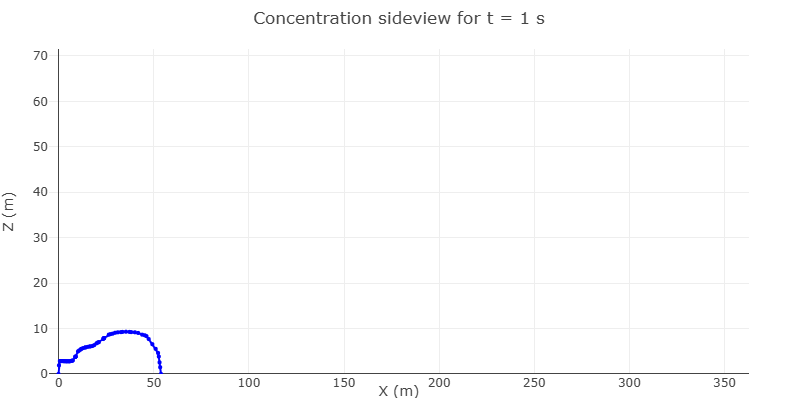

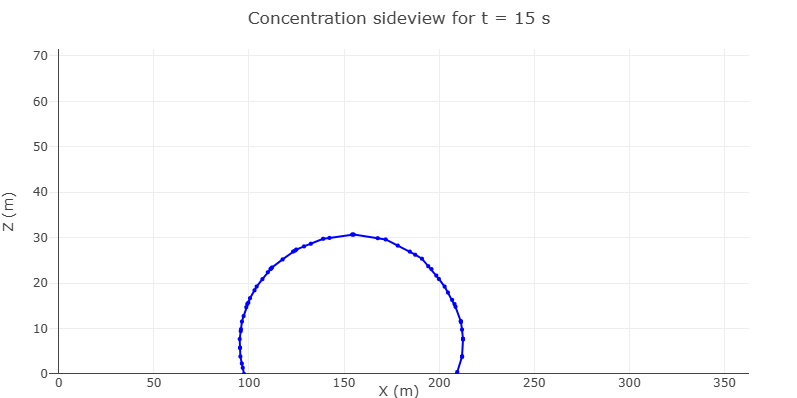

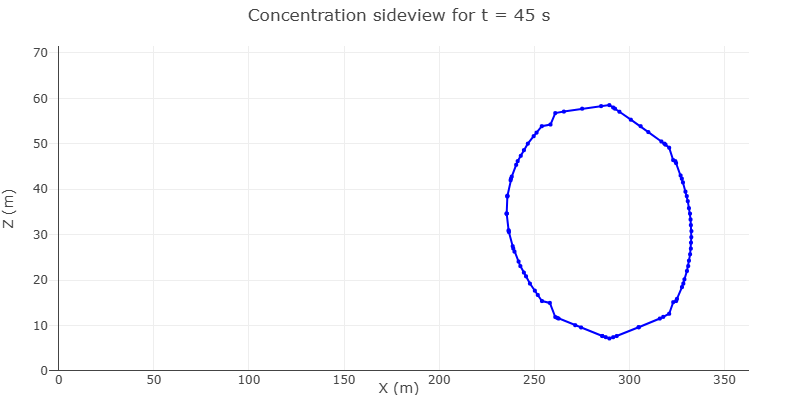

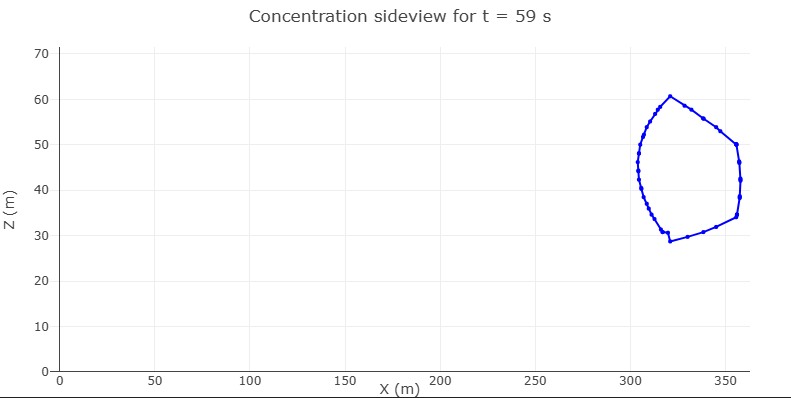

In [11]:
// Create plots for selected time steps to show evolution
const selectedTimes = [1, 15, 30, 45, 59];

for (const time of selectedTimes) {
    const data = contourDataByTime.find(d => d.time === time);
    if (data) {
        const plotData: Partial<Plotly.PlotData> = {
            x: data.x,
            y: data.z,
            type: 'scatter',
            mode: 'lines+markers',
            name: `Concentration contour`,
            line: { color: 'blue', width: 2 },
            marker: { size: 4, color: 'blue' }
        };

        const layout: Partial<Plotly.Layout> = {
            title: `Concentration sideview for t = ${time} s`,
            xaxis: { 
                title: 'X (m)',
                range: [minXValue - xBuffer, maxXValue + xBuffer]
            },
            yaxis: { 
                title: 'Z (m)',
                range: [0, maxZValue + zBuffer]
            },
            showlegend: false,
            width: 800,
            height: 400
        };

        await Plotly.newPlot(tslab, [plotData], layout);
    }
}

### Create a combined plot showing multiple time steps
This shows the evolution of the dispersion cloud over time in a single plot.

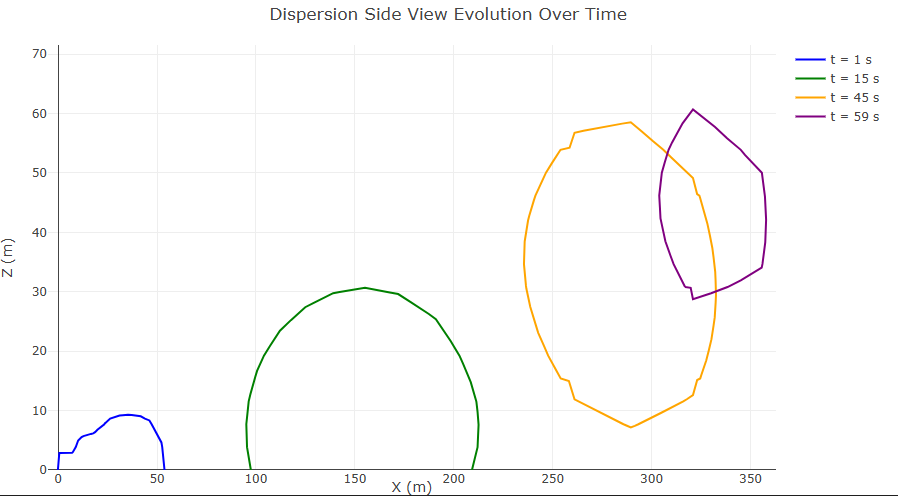

In [12]:
// Create a combined plot showing multiple time steps
const combinedPlotData = [];
const colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'];

for (let i = 0; i < selectedTimes.length; i++) {
    const time = selectedTimes[i];
    const data = contourDataByTime.find(d => d.time === time);
    if (data) {
        combinedPlotData.push({
            x: data.x,
            y: data.z,
            type: 'scatter',
            mode: 'lines',
            name: `t = ${time} s`,
            line: { color: colors[i % colors.length], width: 2 }
        });
    }
}

const combinedLayout = {
    title: 'Dispersion Side View Evolution Over Time',
    xaxis: { 
        title: 'X (m)',
        range: [minXValue - xBuffer, maxXValue + xBuffer]
    },
    yaxis: { 
        title: 'Z (m)',
        range: [0, maxZValue + zBuffer]
    },
    showlegend: true,
    width: 900,
    height: 500
};

await Plotly.newPlot(tslab, combinedPlotData, combinedLayout);